In [1]:
# Preamble and imports

# If you get CUDA errors, quit Jupyter, run these shell commands, and restart Jupyter
# export CUDA_HOME=/pkgs_local/cuda-9.0
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/pkgs_local/cuda-9.0/lib64

# Imports
import os
import argparse
import sys
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

print('Imports ok.')

Imports ok.


In [2]:
# Set Number of Epochs and Batch Size
NUM_EPOCHS = 1
BATCH_SIZE = 50

# Train/test data is not in the Git repo because they are large files.
# Download and unzip "MNIST Basic" and "Rotated MNIST digits" from: http://www.iro.umontreal.ca/~lisa/twiki/bin/view.cgi/Public/MnistVariations

# Place in a folder called "data" or edit the paths below


# Data Sources

# === TRAIN ===

# Basic
B_TRAIN_DATA = "data/mnist_train.amat"
# Rotated
R_TRAIN_DATA = "data/mnist_all_rotation_normalized_float_train_valid.amat"


## === TEST ===

# Basic
B_TEST_DATA = "data/mnist_test.amat"
# Rotated
R_TEST_DATA = "data/mnist_all_rotation_normalized_float_test.amat"

print("OK.")

OK.


In [3]:
# Helper functions to read Montreal data

## CASEY NOTE: new function to read the .amat
PIXELS = 784
CLASSES = 10
def readAmat(filename):
    array = np.loadtxt(filename)
    # see https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.split.html#numpy-split
    data, labels = np.split(array, [PIXELS], axis=1)
    return data, labels

## CASEY NOTE: new function to get batches
## from https://stackoverflow.com/questions/49858574/how-to-implement-correctly-next-batch-in-custom-dataset-in-tensorflow
def next_batch(num, data, labels):
    '''
    Return a total of maximum `num` random samples and labels.
    NOTE: The last batch will be of size len(data) % num
    '''
    num_el = data.shape[0]
    while True: # or whatever condition you may have
        idx = np.arange(0 , num_el)
        np.random.shuffle(idx)
        current_idx = 0
        while current_idx < num_el:
            batch_idx = idx[current_idx:current_idx+num]
            current_idx += num
            data_shuffle = [data[ i,:] for i in batch_idx]
            labels_shuffle = [labels[ i] for i in batch_idx]
            yield np.asarray(data_shuffle), np.asarray(labels_shuffle)
            
print("OK.")

OK.


In [4]:
## LOAD DATA (this takes a few seconds)

print("Loading train data...")
b_train_data, b_train_labels = readAmat(B_TRAIN_DATA)
r_train_data, r_train_labels = readAmat(R_TRAIN_DATA)
b_train_len = b_train_labels.shape[0]
r_train_len = r_train_labels.shape[0]

b_train_labels = b_train_labels.squeeze() # Resize from (50000, 1) to (50000,)
r_train_labels = r_train_labels.squeeze() # Resize from (50000, 1) to (50000,)
print("Train data loaded ({} basic, {} rotated)".format(b_train_len, r_train_len))

print("Loading test data (this takes a few seconds)...")
b_test_data, b_test_labels = readAmat(B_TEST_DATA)
r_test_data, r_test_labels = readAmat(R_TEST_DATA)
b_test_len = b_test_labels.shape[0]
r_test_len = r_test_labels.shape[0]

b_test_labels = b_test_labels.squeeze() # Resize from (50000, 1) to (50000,)
r_test_labels = r_test_labels.squeeze() # Resize from (50000, 1) to (50000,)
print("Test data loaded ({} basic, {} rotated)".format(b_test_len, r_test_len))

Loading train data...
Train data loaded (12000 basic, 12000 rotated)
Loading test data (this takes a few seconds)...
Test data loaded (50000 basic, 50000 rotated)


In [17]:
# Redefine model, per https://colab.research.google.com/drive/1fm5dXC5C4C85q4hCyq9ite2mERujWezM#scrollTo=cJcgZ-svxfrH&forceEdit=true&offline=true&sandboxMode=true

tf.reset_default_graph()

src_map = {0:'b', 1:'r'}

def make_network():
    images = tf.placeholder(tf.float32, [None, 28, 28, 3], name='input')
    labels = tf.placeholder(tf.int64, [None])
    training = tf.Variable(True, name='training')

    conv1 = tf.layers.conv2d(
      inputs=images,
      filters=33,
      kernel_size=5,
      padding="same",
      activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(
      inputs=conv1,
      pool_size=[2, 2],
      strides=2)
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(
      inputs=conv2,
      pool_size=[2, 2],
      strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024,
                          activation=tf.nn.relu)
    dense = tf.layers.dropout(inputs=dense, rate=0.5, training=training)
    tf.identity(dense, 'features')
    logits = tf.layers.dense(inputs=dense, units=10)
    tf.identity(logits, 'logits')

    return images, labels, logits, training

def make_train_op(logits):
    correct_prediction = tf.equal(tf.argmax(logits, axis=1), labels)
    accuracy_tensor = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    loss_tensor = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss_tensor, tf.train.get_or_create_global_step())
    return train_op, loss_tensor, accuracy_tensor
            
# Compute final test acc
def calcTestAcc(sess, test_data, test_labels, loss_tensor, accuracy_tensor):
    print("Running batched test acc calculation...")
    sess.run(training.assign(False)) # this turns dropout off

    # run test step many times!
    batch_size_test = BATCH_SIZE
    n_batches_test = int(len(test_labels) / batch_size_test)
    # print("n_batches_test: {}".format(n_batches_test))
    next_batch_generator = next_batch(num=batch_size_test, data=test_data, labels=test_labels)
    
    total = 0.0
    sum_count = 0
    for i in range(1):
        for j in range(n_batches_test):
            step_t = n_batches_test*i+j
            batch_x, batch_y = next(next_batch_generator)
            batch_x = batch_x.reshape([-1, 28, 28, 1])
            batch_x = np.tile(batch_x, 3) # Because lucid needs 3 channels
            loss, accuracy = sess.run([loss_tensor, accuracy_tensor], feed_dict={images: batch_x, labels: batch_y})
            total += accuracy
    mean_test_acc = total / n_batches_test
    return mean_test_acc

            
def train_for_baseline(sess, train_op, loss_tensor, accuracy_tensor, train_data, train_labels, results, rb, step_index):
    
    # run training step many times!
    batch_size = BATCH_SIZE
    n_batches = int(len(train_labels) / batch_size)
    print("n_batches: {}".format(n_batches))
    next_batch_generator = next_batch(num=batch_size, data=train_data, labels=train_labels)
    
    for i in range(NUM_EPOCHS):
        for j in range(n_batches):
            step = n_batches*i+j
            # print("running batch {}".format(i))
            batch_x, batch_y = next(next_batch_generator)
            batch_x = batch_x.reshape([-1, 28, 28, 1])
            batch_x = np.tile(batch_x, 3) # Because lucid needs 3 channels
            sess.run(train_op, feed_dict={images: batch_x, labels: batch_y})
            if (step % 100 == 0):
                loss, accuracy = sess.run([loss_tensor, accuracy_tensor], feed_dict={images: batch_x, labels: batch_y})
                print("Epoch {} | Step {}, training accuracy {:.2f}%".format(i, step, accuracy*100.0))
                
                b_acc = calcTestAcc(sess, b_test_data, b_test_labels, loss_tensor, accuracy_tensor)
                results[rb][0].append(b_acc)
                print("trained on {} | test on {} | Appending accuracy {}".format(src_map[rb], "b", b_acc))
                
                r_acc = calcTestAcc(sess, r_test_data, r_test_labels, loss_tensor, accuracy_tensor)
                results[rb][1].append(r_acc)
                print("trained on {} | test on {} | Appending accuracy {}".format(src_map[rb], "r", r_acc))
                
                if (rb == 0):
                    step_index.append(step)
                            
print('OK.')

OK.


In [18]:
images, labels, logits, training = make_network()
train_op, loss_tensor, accuracy_tensor = make_train_op(logits)
            
print('OK.')

OK.


In [19]:
# Populate nparray with accuracies over training time on both sets

results = [None] * 2
results[0] = [None] * 2
results[1] = [None] * 2

results[0][0] = []
results[0][1] = []
results[1][0] = []
results[1][1] = []

step_index = []

rb = 0

for train_data, train_labels in [(b_train_data, b_train_labels), (r_train_data, r_train_labels)]:
    print("Starting train on {}".format(src_map[rb]))
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    train_for_baseline(sess, train_op, loss_tensor, accuracy_tensor, train_data, train_labels, results, rb, step_index)
    rb += 1

Starting train on b
n_batches: 240
Epoch 0 | Step 0, training accuracy 36.00%
Running batched test acc calculation...
trained on b | test on b | Appending accuracy 0.21851999945566059
Running batched test acc calculation...
trained on b | test on r | Appending accuracy 0.14295999988913535
Epoch 0 | Step 100, training accuracy 94.00%
Running batched test acc calculation...
trained on b | test on b | Appending accuracy 0.9580599991083145
Running batched test acc calculation...
trained on b | test on r | Appending accuracy 0.25918000014871356
Epoch 0 | Step 200, training accuracy 100.00%
Running batched test acc calculation...
trained on b | test on b | Appending accuracy 0.9691800015568733
Running batched test acc calculation...
trained on b | test on r | Appending accuracy 0.2624599997922778
Starting train on r
n_batches: 240
Epoch 0 | Step 0, training accuracy 18.00%
Running batched test acc calculation...
trained on r | test on b | Appending accuracy 0.10001999942958355
Running batche

In [12]:
# Call this for cleanup at the end
sess.close()
print("TF session closed.")

TF session closed.


0.96,0.27,0.52,0.86
200


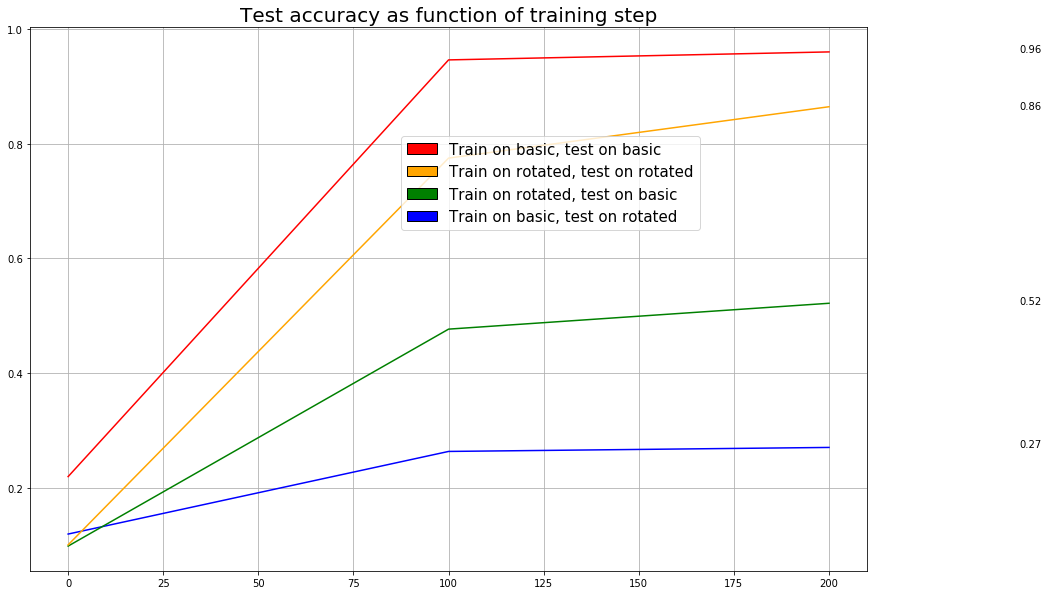

In [13]:
# Plot the accuracies

from matplotlib.patches import Rectangle

tr_b_test_b = results[0][0]
tr_b_test_r = results[0][1]
tr_r_test_b = results[1][0]
tr_r_test_r = results[1][1]

a = [ '%.2f' % elem for elem in tr_b_test_b ]
b = [ '%.2f' % elem for elem in tr_b_test_r ]
c = [ '%.2f' % elem for elem in tr_r_test_b ]
d = [ '%.2f' % elem for elem in tr_r_test_r ]

a_f = a[-1]
b_f = b[-1]
c_f = c[-1]
d_f = d[-1]

print("{},{},{},{}".format(a_f, b_f, c_f, d_f))

print(step_index[-1])
last_step = step_index[-1]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))

plt.plot(step_index, results[0][0], color="red")
plt.plot(step_index, results[0][1], color="blue")
plt.plot(step_index, results[1][0], color="green")
plt.plot(step_index, results[1][1], color="orange")

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red","orange","green","blue"]]
labels = ["Train on basic, test on basic",
          "Train on rotated, test on rotated",
          "Train on rotated, test on basic",
          "Train on basic, test on rotated"
          ]
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)


plt.legend(handles, labels, bbox_to_anchor=(0.8, 0.8), loc=1, borderaxespad=0.)
plt.grid()
plt.title("Test accuracy as function of training step", fontsize=20)

gap = 50
plt.text(last_step+gap, float(a_f), str(a_f))
plt.text(last_step+gap, float(b_f), str(b_f))
plt.text(last_step+gap, float(c_f), str(c_f))
plt.text(last_step+gap, float(d_f), str(d_f))

plt.show()